In [1]:
import math
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = '/Users/linshoahchieh/Documents/Kaggle/mobile_price_prediction/data'
train_path = data_dir + '/train.csv'
#test_path = data_dir + '/test.csv'

train = pd.read_csv(train_path)
#test = pd.read_csv(test_path) #test_set doesn't have label 
print('Dataset size: {}'.format(train.shape))

# Check label distribution
## The labels are equally distributed.
# sns.countplot(train['price_range'])


Dataset size: (2000, 21)


# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

/Users/linshoahchieh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price_range', ylabel='count'>

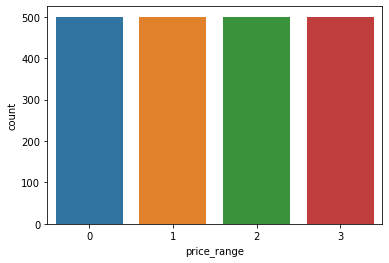

In [4]:
# Target (price_range)
# Our goal is to predict the price range. The target is order data (from 0 to 3) and it's balanced.
sns.countplot(train['price_range'])

ram
0.9170457362649902
price_range
1.0


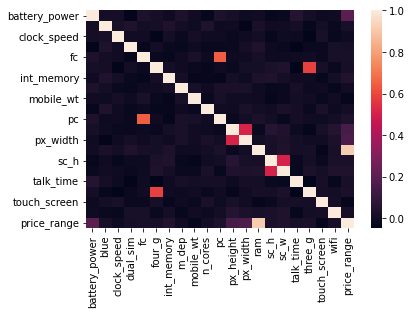

In [5]:
# Correlation plot
# It seems that only ram is associated with the target.

sns.heatmap(train.corr())

corr_series = train.corr().iloc[-1]
for i in range(len(corr_series)):
    if np.abs(corr_series[i]) >= 0.3:
        print(corr_series.index[i])
        print(corr_series[i])

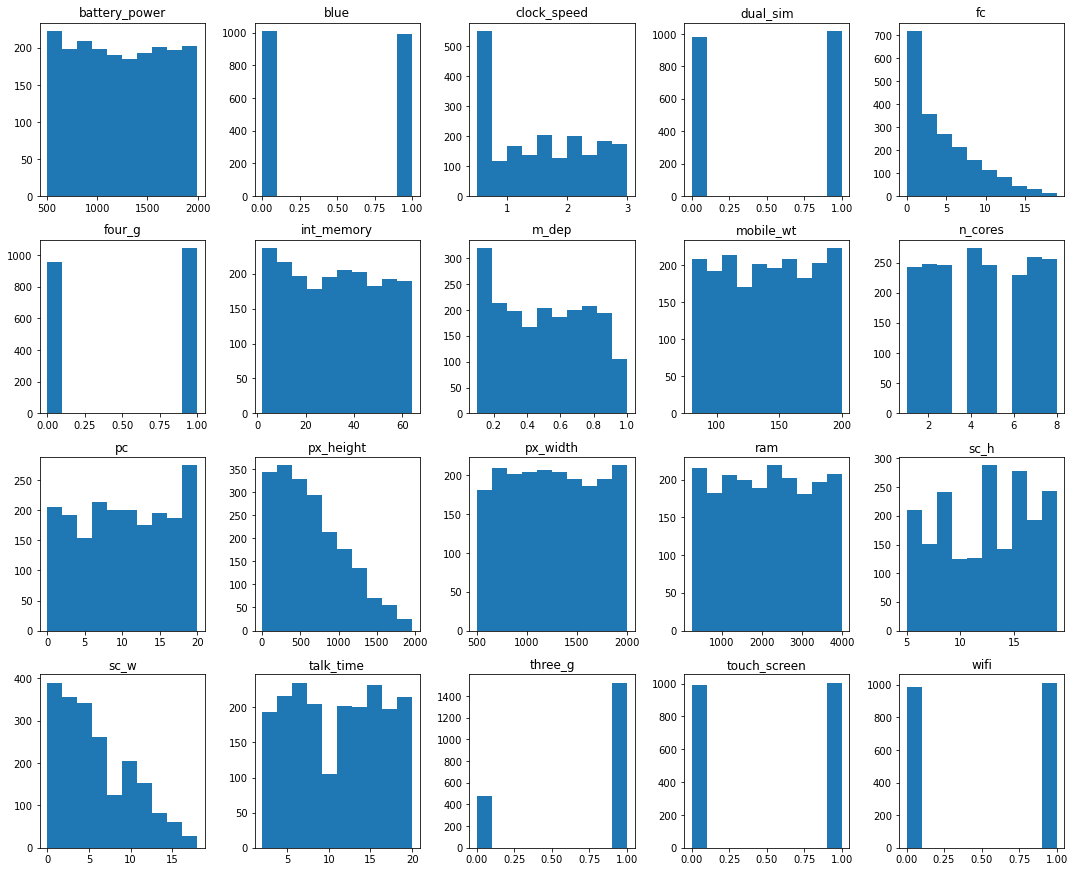

In [6]:
plt.figure(figsize=(15,15))

i = 1
for col in train.columns[:-1]:
    plt.subplot(5,5,i)
    plt.hist(train[col])
    plt.title(col)
    i += 1

plt.tight_layout()

In [7]:
# Outliers?

def get_outliers(arr, n_std):
    mean = np.mean(arr)
    std = np.std(arr)
    ths = [mean-n_std*std, mean+n_std*std]
    return np.where(np.logical_or(arr < ths[0], arr>ths[1]))[0]

for col in train.columns:
    arr_outliers = get_outliers(train[col], n_std=3)
    if len(arr_outliers) == 0:
        pass
    else:
        print(col)
        print(arr_outliers)

fc
[  95  226  305 1387 1406 1416 1554 1693 1705 1880 1882 1888]


# Data Preparation

Discussion:
1. Standardized vs not-standardized
2. PCA vs non-PCA

In [8]:
# Keep 400 rows as the validation dataset
random.seed(2022)
n_val = 400
val_indices = train.sample(n_val).index.to_list()
val_set = train.iloc[val_indices]
train_set = train[train.index.isin(val_indices) == False]

print('Train dataset size: {}'.format(train_set.shape))
print('Validation dataset size: {}'.format(val_set.shape))

X_train = train_set.iloc[:, :-1].to_numpy()
y_train = train_set.iloc[:, -1].to_numpy()

X_val = val_set.iloc[:, :-1].to_numpy()
y_val = val_set.iloc[:, -1].to_numpy()

Train dataset size: (1600, 21)
Validation dataset size: (400, 21)


In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

# Clustering

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [11]:
# TSNE & PCA
X_red_TSNE = TSNE().fit_transform(X_train)
X_red_PCA = PCA(n_components=2).fit_transform(X_train)

/Users/linshoahchieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/linshoahchieh/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


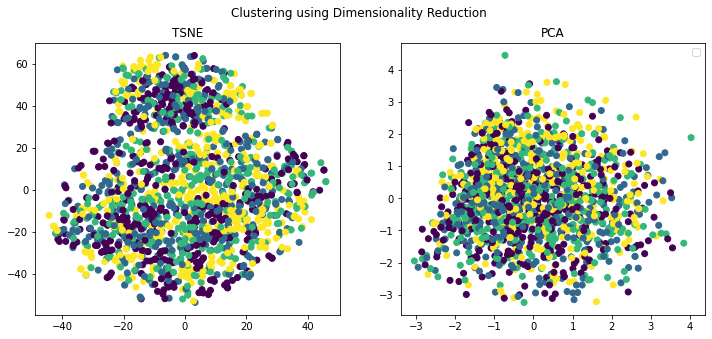

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
f.suptitle('Clustering using Dimensionality Reduction')

ax2.scatter(X_red_PCA[:,0], X_red_PCA[:,1], c=y_train)
ax2.set_title('PCA')

ax1.scatter(X_red_TSNE[:,0], X_red_TSNE[:,1], c=y_train)
ax1.set_title('TSNE')

plt.legend()

# Training 1: Model Comparison

Models: 
1. Decision Tree
2. Random Forest
3. AdaBoost
4. SVC with higher level kernels

Training Samples:
100 ~ 1600

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import LinearSVC,SVC 
from sklearn.base import clone

In [14]:
def training(clf, X_train, X_test, y_train, y_test):

    # Prepare different size of training set
    n_train = list(range(100, 1600, 100))

    # train_log 
    train_log = dict()
    train_log['n_train'] = list()
    train_log['test_acc'] = list()
    
    for n in n_train:
        X_sampled = X_train[:n]
        y_sampled = y_train[:n]
        clf_clone = clone(clf)
        clf_clone.fit(X_sampled, y_sampled)

        # logging
        train_log['n_train'].append(n)
        train_log['test_acc'].append(clf_clone.score(X_test, y_test))

    return train_log

In [15]:
dt = DecisionTreeClassifier()
log_dt = training(dt, X_train, X_val, y_train, y_val)

rf = RandomForestClassifier()
log_rf = training(rf, X_train, X_val, y_train, y_val)

ada = AdaBoostClassifier()
log_ada = training(rf, X_train, X_val, y_train, y_val)

svc = SVC()
log_svc = training(svc, X_train, X_val, y_train, y_val)

Text(0, 0.5, 'Test Accuracy')

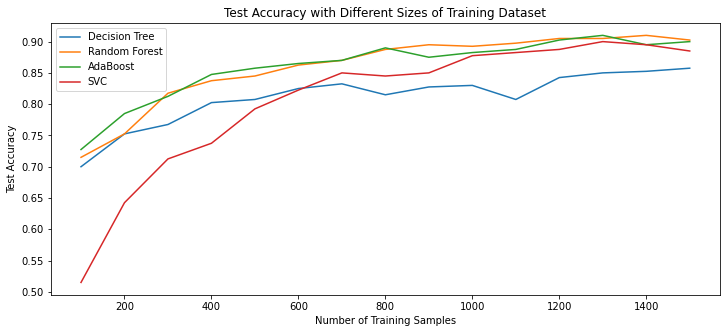

In [16]:
plt.figure(figsize=(12,5))

plt.plot(log_dt['n_train'], log_dt['test_acc'], label='Decision Tree')
plt.plot(log_rf['n_train'], log_rf['test_acc'], label='Random Forest')
plt.plot(log_ada['n_train'], log_ada['test_acc'], label='AdaBoost')
#plt.plot(log_lsvc['n_train'], log_lsvc['test_acc'], label='LinearSVC')
plt.plot(log_svc['n_train'], log_svc['test_acc'], label='SVC')


plt.legend()
plt.title('Test Accuracy with Different Sizes of Training Dataset')

plt.xlabel('Number of Training Samples')
plt.ylabel('Test Accuracy')

# Training 2: PCA Effects

Models: 
1. Decision Tree
2. Random Forest
3. AdaBoost
4. SVC with higher level kernels

Training Samples:
1600

Comparison, before and after PCA

In [17]:
def training_PCA(clf, X_train, X_test, y_train, y_test):

    train_log = dict()
    train_log['n_components'] = list(range(2,21))
    train_log['test_acc'] = list()

    for n in range(2,21):
        pca = PCA(n_components=n)
        X_train_red = pca.fit_transform(X_train)
        X_test_red = pca.transform(X_test)
        clf_clone = clone(clf)
        clf_clone.fit(X_train_red, y_train)
        test_acc = clf_clone.score(X_test_red, y_test)
        train_log['test_acc'].append(test_acc)
        
    return train_log

In [18]:
dt = DecisionTreeClassifier()
log_dt = training_PCA(dt, X_train, X_val, y_train, y_val)

rf = RandomForestClassifier()
log_rf = training_PCA(rf, X_train, X_val, y_train, y_val)

ada = AdaBoostClassifier()
log_ada = training_PCA(rf, X_train, X_val, y_train, y_val)

svc = SVC()
log_svc = training_PCA(svc, X_train, X_val, y_train, y_val)

Text(0, 0.5, 'Test Accuracy')

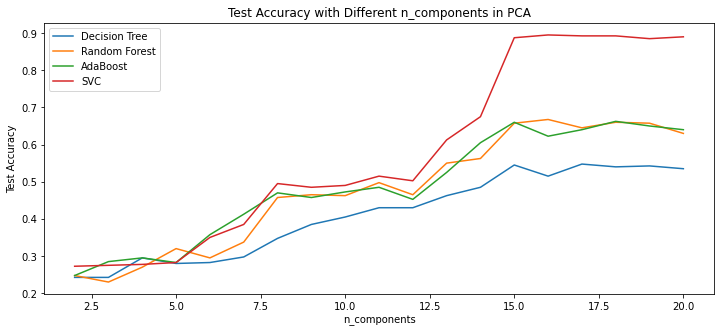

In [19]:
plt.figure(figsize=(12,5))

plt.plot(log_dt['n_components'], log_dt['test_acc'], label='Decision Tree')
plt.plot(log_rf['n_components'], log_rf['test_acc'], label='Random Forest')
plt.plot(log_ada['n_components'], log_ada['test_acc'], label='AdaBoost')
plt.plot(log_svc['n_components'], log_svc['test_acc'], label='SVC')

plt.legend()
plt.title('Test Accuracy with Different n_components in PCA')
plt.xlabel('n_components')
plt.ylabel('Test Accuracy')